# Filtering --- Apply Classification-Meta-Data Report Filter

## What is the goal of this notebook
The purposes of this notebook are:
- To develop and test code for /web_app_atw/wranglings_scripts/filter_data.py
- The output of this nnotebook is not needed for the web app 
- This notebook is just a test for datetime and classification object filters and their interplay.

# How does it work?
- The baseline for this notebook is Classification-Meta-Data-Report file ***images.pkl***
- This file will be read in and based on the user filter settings different filter scenarios are tested.

## What has still to be done in the future?
In the future will be implemented:
- a GPS filter via the haversine method. This will allow you to filter images based on adjustable radial distances referred to a provided GPS location (longitude and latitude). 

### Content
[Libraries](#lib)<br>
[Load DataFrame](#LoadDataFrame)<br>
[Get Yolo and ImageNet combined class lists](#CombinedClassLists)<br>
[Filter by DateTime](#filter_datetime)<br>
[Filter by ImageNet and Yolo Classification](#filter_class)<br>
[Generate an image info set](#image_info_sidebox)<br>
[Set the data dictionary for filtering](#data_dic)<br>
[Check Filter Settings and Start Filtering](#start_filter)<br>

[Export an HTML Table of the filter result for web page](#html_table)<br>


### <a class="anchor" id="lib">Libraries</a>

In [1]:
import pandas as pd
import ast
import os

from PIL import Image, ImageDraw, ExifTags, ImageTk
import base64
import io
from io import StringIO, BytesIO

from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))

    
MEDIA_FOLDER = './images/'

# current working directory
cwd = os.path.abspath(os.getcwd())
MEDIA_FOLDER = os.path.join(cwd, 'images')
path_to_class_meta_report = os.path.join(cwd, 'images.pkl')
print(cwd)
print(MEDIA_FOLDER)
print(path_to_class_meta_report)

/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data
/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images
/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images.pkl


### <a class="anchor" id="LoadDataFrame">Load DataFrame</a>

In [2]:
def load_data(path):
    """ Load pkl file with classification and meta data results
    
        INPUTS:
        ------------
            path - (string) path to classification report
        
        OUTPUTS:
        ------------
        df (pandas dataframe) containing the classification report
    """
    
    df = pd.read_pickle(path)
    try: 
        del df['Unnamed: 0']
    except:
        pass
        
    return df

### <a class="anchor" id="CombinedClassLists">Get Yolo and ImageNet combined class lists</a>

In [3]:
def perfectEval(anonstring):
    """ Transform string elements in dataframe columns to lists via ast module
        
        INPUTS:
        ------------
            anonstring - (string) a string in the form "['elmt1', 'elmt2', 'elmt2', ...]" 
                         which should be transformed  to a list as ['elmt1', 'elmt2', 'elmt2', ...]
        
        OUTPUTS:
        ------------
            ev (list) - a list transformation of the input string
    """
    try:
        ev = ast.literal_eval(anonstring)
        return ev
    except ValueError:
        corrected = "\'" + str(anonstring) + "\'"
        ev = ast.literal_eval(corrected)
        return ev

def get_yolo_and_imagenet_lists(path):
    """ Extract Yolo lists and ImageNet classification lists from the Classification-Meta-Data report.
        Those lists are needed for web app select menus and for displaying filter results
        
        INPUTS:
        ------------
            path - (string) path to classification report
        
        OUTPUTS:
        ------------
            df - (pandas dataframe) of the classification report
            yolo_flat_list - (list) of all in df observed Yolo classes
            imageNet_flat_list - (list) of all in df observed ImageNet classes
            
    """
    
    df = load_data(path)
    # yolo classifications
    yolo_list = df['classes_yolo'].tolist()
    yolo_flat_list = [item for sublist in yolo_list for item in sublist]
    yolo_flat_list = list(set(yolo_flat_list))
    #print('yolo_flat_list', yolo_flat_list)
    
    # ImageNet classifications
    imageNet_list = df['classes_ImgNet'].tolist()
    imageNet_flat_list = [item for sublist in imageNet_list for item in sublist]
    imageNet_flat_list = list(set(imageNet_flat_list))
    #print('imageNet_flat_list', imageNet_flat_list)


    return df, yolo_flat_list, imageNet_flat_list

def create_combined_class_list(path):
    """ Create a list of combined Yolo and ImageNEt lists
        
        INPUTS:
        ------------
            path - (string) path to classification report
        
        OUTPUTS:
        ------------
            df - (pandas dataframe) of the the classification report
            combined_class_list - (list) of combined Yolo and ImageNEt lists
            yolo_flat_list - (list) of all in df observed Yolo classes
            imageNet_flat_list - (list) of all in df observed ImageNet classes
    """
    
    df, yolo_flat_list, imageNet_flat_list = get_yolo_and_imagenet_lists(path)
    
    yolo_flat_list = sorted(yolo_flat_list)
    imageNet_flat_list = sorted(imageNet_flat_list)

    combined_class_list = yolo_flat_list
    combined_class_list.extend(imageNet_flat_list)
    combined_class_list = sorted(combined_class_list)
    combined_class_list.insert(0,'Open this select menu')

    return df, combined_class_list, yolo_flat_list, imageNet_flat_list


df, combined_class_list, yolo_flat_list, imageNet_flat_list = create_combined_class_list(path_to_class_meta_report)

In [20]:
printmd('#### Column names of df')
print(df.columns)
printmd('df DataFrame')
display(df.head())

#### Column names of df

Index(['file', 'path_to_file', 'readable', 'date_time', 'orientation', 'width',
       'height', 'rotation_angle', 'flip', 'GPS', 'state_after_rot',
       'img_path_yolo', 'classes_yolo', 'classes_ImgNet', 'classes_ImgNet_idx',
       'class_ImgNet_add', 'imgnet_choice', 'yolo_choice'],
      dtype='object')


df DataFrame

,file,path_to_file,readable,date_time,orientation,width,height,rotation_angle,flip,GPS,state_after_rot,img_path_yolo,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add,imgnet_choice,yolo_choice
0,1.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/1.jpg,True,2019-03-19 10:35:48,1,4032,3024,0,NO,"(55.86449189238991, -4.4298895959595965)",no change,./images_yolo/1.jpg,"[person, person]",[street_sign],919,"[([street_sign], 22.165002822875977), ([moving_van], 11.253789901733398), ([wing], 8.379040718078613), ([traffic_light, traffic_signal, stoplight], 6.293417453765869), ([ambulance], 5.369166851043701)]",True,True
1,2.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/2.jpg,True,2019-03-19 10:51:33,1,4032,3024,0,NO,"(55.86182953710507, -4.41538315539739)",no change,./images_yolo/2.jpg,"[car, car, car, car, car]",[car_mirror],475,"[([car_mirror], 19.255046844482422), ([minivan], 15.607881546020508), ([limousine, limo], 13.92467212677002), ([wing], 13.895726203918457), ([convertible], 11.028861045837402)]",True,False
2,3.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/3.jpg,True,2019-03-19 10:57:03,1,4032,3024,0,NO,"(55.84993888888889, -4.287311111111111)",no change,./images_yolo/3.jpg,"[car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 21.303001403808594), ([trailer_truck, tractor_trailer, trucking_rig, rig, articulated_lorry, semi], 13.868844985961914), ([passenger_car, coach, carriage], 6.869407653808594), ([freight_car], 5.0408477783203125), ([streetcar, tram, tramcar, trolley, trolley_car], 4.72355318069458)]",True,False
3,4.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/4.jpg,True,2019-03-19 11:57:46,1,4032,3024,0,NO,"(55.913596908117555, -4.435347215371631)",no change,./images_yolo/4.jpg,"[car, car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 34.03543472290039), ([streetcar, tram, tramcar, trolley, trolley_car], 10.615340232849121), ([trolleybus, trolley_coach, trackless_trolley], 3.8722434043884277), ([car_mirror], 3.1056997776031494), ([mobile_home, manufactured_home], 2.8439457416534424)]",True,False
4,5.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/5.jpg,True,2019-03-19 11:57:49,1,4032,3024,0,NO,"(55.91388110002696, -4.435910787253153)",no change,./images_yolo/5.jpg,"[car, car, car, car, car, car, car, truck]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 26.575984954833984), ([triumphal_arch], 11.212915420532227), ([car_mirror], 6.99009370803833), ([minivan], 4.328091621398926), ([limousine, limo], 3.8021080493927)]",True,True


In [5]:
printmd('#### First 100 elements of combined_class_list')
print(combined_class_list[:100])

#### First 100 elements of combined_class_list

['Open this select menu', 'boathouse', 'car', 'car_mirror', 'person', 'pole', 'stoplight', 'street_sign', 'thatch', 'thatched_roof', 'traffic light', 'traffic_light', 'traffic_signal', 'truck']


### <a class="anchor" id="first_last_dt">Get first and last datetime value from data set</a>

In [24]:
def get_first_lat_datetime_value(df):
    """ Filter Classification Report via datetime (start and end datetime)
        
        INPUTS:
        ------------
            df - (pandas dataframe) of the the classification report
            data - (dictionary) used for filtering and output data storage
        
        OUTPUTS:
        ------------
            first_dt - (datetime) first date in in dataset
            last_dt - (datetime) last date in dataset
    """
    
    # first  datetime entry
    first_dt = df['date_time'].iloc[0].date()
    print(first_dt)
   
    # last datetime entry
    last_dt = df['date_time'].iloc[-1].date()
    print(last_dt)
   
    
    return first_dt, last_dt
    
get_first_lat_datetime_value(df)

2019-03-19
2019-03-19


(datetime.date(2019, 3, 19), datetime.date(2019, 3, 19))

### <a class="anchor" id="filter_datetime">Filter by DateTime</a>

In [6]:
# Filter by datetimes
def filter_by_datetime(df, data):
    """ Filter Classification Report via datetime (start and end datetime)
        
        INPUTS:
        ------------
            df - (pandas dataframe) of the the classification report
            data - (dictionary) used for filtering and output data storage
        
        OUTPUTS:
        ------------
            df_filter - (pandas dataframe) of the the classification report 
                        filtered by datetime start and end point
    """
    
    datetime_filter_lower = df['date_time'] >= data['start_date']
    datetime_filter_upper = df['date_time'] <=  data['end_date']
    

    # Select all cases where df['date_time'] >= start_datetime and df['date_time'] <= end_datetime
    df_filter = df[datetime_filter_lower & datetime_filter_upper]
    df_filter.sort_values('date_time', inplace=True, ascending=True)

    return df_filter

#df_filter = filter_by_datetime(df, data)

#display(df_filter)
#printmd('### Shape of df_filter ' + str(df_filter.shape))

### <a class="anchor" id="filter_class">Filter by ImageNet and Yolo Classification</a>

In [7]:
def filter_by_class(df, data):
    """ Filter Classsification Report based on certain class items of Yolo and ImageNet
        
        INPUTS:
        ------------
            df - (pandas dataframe) of the the classification report
            data - (dictionary) sed for filtering and output data storage
        
        
        OUTPUTS:
        ------------
            df_filter - (pandas dataframe) of the the classification report 
                        filtered by class items of Yolo and ImageNet
    """
    
    selected_list = [data['selected_1'], 
                     data['selected_2'], 
                     data['selected_3'], 
                     data['selected_4'], 
                     data['selected_5'], 
                     data['selected_6'], 
                     data['selected_7'], 
                     data['selected_8']]
    
    
    
    if set(selected_list) == {'Open this select menu'}:
        """
        Mode 1: All Selectboxes are set to 'Open this select menu' --> No Class Filtering
        """
        return df
    
    
    else:
        """
        Mode 2: Apply class filter
        """
        df['imgnet_choice'] = df['classes_ImgNet'].apply(lambda x: any([k in str(x) for k in selected_list]))
        df['yolo_choice'] = df['classes_yolo'].apply(lambda x: any([k in str(x) for k in selected_list]))
        
        df_filter = df[(df['imgnet_choice'] == True) | (df['yolo_choice'] == True)]
    
    return df_filter

#try:
    
#    df_filter = filter_by_class(df_filter, data)
#except:
#    df_filter = filter_by_class(df, data)

#display(df_filter)
#printmd('### Shape of df_filter ' + str(df_filter.shape))

### <a class="anchor" id="image_info_sidebox">Generate an image info set</a>

In [8]:
def create_image_infosets(df_filter, data):
    """ 1. Get info of images (image_path, gps, datetime, classification) and prepare it as info sets for web app
        2. Updata data['image_set'] based on fildering
        
        INPUTS:
        ------------
            df_filter - (pandas dataframe) of the the classification report 
                        filtered by datetime AND class items of Yolo and ImageNet
        
        OUTPUTS:
        ------------
            df_filter - (pandas dataframe) of the the classification report 
                        GPS info corrected for Google Maps, must be string of tuple for Google Maps 
            image_set - (list) paths to the actual set of images
            date_time - (list) of datetimes for actual images
            GPS - (list) of GPS coordinates  for actual images
            classes_yolo - (list) of lists od Yolo classes  for actual images
            classes_ImgNet - (list) of lists od ImageNet classes  for actual images
            markers_and_infos - (list) of lists with info of the actual image set 
                                (latitude, longitudes, image set, datetimes, GPS as tuple, yolo and Imagenet classes)
            
    """
    df_filter.loc[df_filter.GPS == '(None, None)', "GPS"] = "('None', 'None')"

    df_filter = df_filter.sort_values('file',ascending=True)

    image_set = [os.path.split(path)[1] for path in df_filter['file'].tolist()]
    
    data['image_set'] = image_set

    date_time = df_filter['date_time'].tolist()
    GPS = eval(str(df_filter['GPS'].tolist()))
    classes_yolo = df_filter['classes_yolo'].tolist()
    classes_ImgNet = df_filter['classes_ImgNet'].tolist()
    
    
    
    print(df_filter['GPS'].tolist())
    lats = [x[0] for x in df_filter['GPS'].tolist()]
    longs = [x[1] for x in df_filter['GPS'].tolist()]
    print(lats)
    markers_and_infos = [lats,
                        longs,
                        image_set,
                        [str(dt) for dt in date_time],
                        GPS,
                        classes_yolo,
                        classes_ImgNet
                        ]

    #for kundex, elmt in enumerate(markers_and_infos[4]):
    #    markers_and_infos[4][kundex] = list(ast.literal_eval(elmt))
    #for kundex, elmt in enumerate(markers_and_infos[5]):
    #    markers_and_infos[5][kundex] = ast.literal_eval(elmt)
    #for kundex, elmt in enumerate(markers_and_infos[6]):
    #    markers_and_infos[6][kundex] = ast.literal_eval(elmt)
        
    data['markers_and_infos'] = markers_and_infos

    return df_filter, data, image_set, date_time, GPS, classes_yolo, classes_ImgNet, markers_and_infos

#df_filter, data, img_path, date_time, GPS, classes_yolo, classes_ImgNet = create_image_infosets(df_filter)

#printmd('#### Shape of df_filter ' + str(df_filter.shape))
#printmd('#### img_path')
#print(img_path)
#print(len(img_path))
#printmd('#### date_time')
#print(date_time)
#print(len(date_time))
#printmd('#### GPS')
#print(GPS)
#print(len(GPS))
#printmd('#### classes_yolo')
#print(classes_yolo)
#print(len(classes_yolo))
#printmd('#### classes_ImgNet')
#print(classes_ImgNet)
#print(len(classes_ImgNet))

### <a class="anchor" id="data_dic">Set the data dictionary for filtering</a>

In [9]:
data = {'class_rep_file_path': MEDIA_FOLDER,
        'google_api': 'YOUR_GOOGLE_API',
        'check_classification': True,
        'check_date': False,
        'check_map': False,
        'selected_1': 'car_mirror',
        'selected_2': 'street_sign', 
        'selected_3': 'pole',
        'selected_4': 'person',
        'selected_5': 'traffic_light',
        'selected_6': 'truck',
        'selected_7': 'Open this select menu',
        'selected_8': 'Open this select menu',
        'start_date': "2014-04-05",
        'end_date': "2014-04-09",
        'combined_class_list': combined_class_list,
        'image_set': [],
        #'markers_and_infos': image_set

        }

### <a class="anchor" id="start_filter">Check Filter Settings and Start Filtering</a>

In [10]:
def get_filtered_data(df_filter, data):
    """ Main function in order to 
        1. filter the classifcation report based on classes and datetimes 
        2. create image infosets for the web app
        
        INPUTS:
        ------------
            df_filter (pandas dataframe) the NON filtered (just loaded dataframe) of the the classification report file
            data - (dictionary) used for filtering and output data storage
            
        OUTPUTS:
        ------------
            df_filter - (pandas dataframe) updated (filtered) dataframe of the the classification report 
            data - (dictionary) updated data dictionary (key 'image_set' is updated)
            image_set - (list) paths to the actual set of images
            date_time - (list) of datetimes for actual images
            GPS - (list) of GPS coordinates  for actual images
            classes_yolo - (list) of lists od Yolo classes  for actual images
            classes_ImgNet - (list) of lists od ImageNet classes  for actual images  
            markers_and_infos - (list) of lists with info of the actual image set 
                                (latitude, longitudes, image set, datetimes, GPS as tuple, yolo and Imagenet classes)
    """
    
    
    # check datetime filter, if checked filter by datetime range
    if data['check_date'] == True:
        print('-------------------------')
        print('   DATE FILTER CHECKED')
        print('-------------------------')
        df_filter = filter_by_datetime(df_filter, data)

    else:
        print('-------------------------')
        print(' DATE FILTER NOT CHECKED')
        print('-------------------------')
        
        

    # check check_classification filter, if checked filter by chosen ImageNet and Yolo classes
    if data['check_classification'] == True:
        print('-------------------------')
        print('  CLASS FILTER CHECKED')
        print('-------------------------')
        df_filter = filter_by_class(df_filter, data)


    else:
        print('-------------------------')
        print('CLASS FILTER NOT CHECKED')
        print('-------------------------')
    
    
    df_filter, data, image_set, date_time, GPS, classes_yolo, classes_ImgNet, markers_and_infos = create_image_infosets(df_filter, data)


    return df_filter, data, image_set, date_time, GPS, classes_yolo, classes_ImgNet, markers_and_infos

df_filter, data, image_set, date_time, GPS, classes_yolo, classes_ImgNet, markers_and_infos = get_filtered_data(df, data)



-------------------------
 DATE FILTER NOT CHECKED
-------------------------
-------------------------
  CLASS FILTER CHECKED
-------------------------
[(55.86449189238991, -4.4298895959595965), (55.86182953710507, -4.41538315539739), (55.84993888888889, -4.287311111111111), (55.913596908117555, -4.435347215371631), (55.91388110002696, -4.435910787253153), (55.91922085170114, -4.45444038380557), (55.9251239190332, -4.458130830086197)]
[55.86449189238991, 55.86182953710507, 55.84993888888889, 55.913596908117555, 55.91388110002696, 55.91922085170114, 55.9251239190332]


/anaconda3/envs/atw_macOS/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
printmd('#### Actual data dictionary')
for key, value in data.items():
    print(key, ' ---- ', value)

#### Actual data dictionary

class_rep_file_path  ----  /Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images
google_api  ----  YOUR_GOOGLE_API
check_classification  ----  True
check_date  ----  False
check_map  ----  False
selected_1  ----  car_mirror
selected_2  ----  street_sign
selected_3  ----  pole
selected_4  ----  person
selected_5  ----  traffic_light
selected_6  ----  truck
selected_7  ----  Open this select menu
selected_8  ----  Open this select menu
start_date  ----  2014-04-05
end_date  ----  2014-04-09
combined_class_list  ----  ['Open this select menu', 'boathouse', 'car', 'car_mirror', 'person', 'pole', 'stoplight', 'street_sign', 'thatch', 'thatched_roof', 'traffic light', 'traffic_light', 'traffic_signal', 'truck']
image_set  ----  ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '9.jpg']
markers_and_infos  ----  [[55.86449189238991, 55.86182953710507, 55.84993888888889, 55.913596908117555, 55.91388110002696, 55.91922085170114, 55.9251239190332], [-4.42988959

In [12]:
printmd('#### Shape of df_filter ' + str(df_filter.shape))
printmd('#### img_path')
print(image_set)
print(len(image_set))
printmd('#### date_time')
print(date_time)
print(len(date_time))
printmd('#### GPS')
print(GPS)
print(len(GPS))
printmd('#### classes_yolo')
print(classes_yolo)
print(len(classes_yolo))
printmd('#### classes_ImgNet')
print(classes_ImgNet)
print(len(classes_ImgNet))

#### Shape of df_filter (7, 18)

#### img_path

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '9.jpg']
7


#### date_time

[Timestamp('2019-03-19 10:35:48'), Timestamp('2019-03-19 10:51:33'), Timestamp('2019-03-19 10:57:03'), Timestamp('2019-03-19 11:57:46'), Timestamp('2019-03-19 11:57:49'), Timestamp('2019-03-19 11:59:25'), Timestamp('2019-03-19 12:00:41')]
7


#### GPS

[(55.86449189238991, -4.4298895959595965), (55.86182953710507, -4.41538315539739), (55.84993888888889, -4.287311111111111), (55.913596908117555, -4.435347215371631), (55.91388110002696, -4.435910787253153), (55.91922085170114, -4.45444038380557), (55.9251239190332, -4.458130830086197)]
7


#### classes_yolo

[['person', 'person'], ['car', 'car', 'car', 'car', 'car'], ['car', 'car', 'car'], ['car', 'car', 'car', 'car'], ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'truck'], [], ['person', 'car', 'traffic light']]
7


#### classes_ImgNet

[['street_sign'], ['car_mirror'], ['traffic_light', 'traffic_signal', 'stoplight'], ['traffic_light', 'traffic_signal', 'stoplight'], ['traffic_light', 'traffic_signal', 'stoplight'], ['pole'], ['car_mirror']]
7


In [13]:
printmd('#### markers_and_infos')
info_names =['lats','longs','image_set', 'date_times', 'GPS', 'classes_yolo', 'classes_ImgNet']
                        
for info_name, element in zip(info_names, markers_and_infos):
    printmd('#### ' + str(info_name))
    print(element)

#### markers_and_infos

#### lats

[55.86449189238991, 55.86182953710507, 55.84993888888889, 55.913596908117555, 55.91388110002696, 55.91922085170114, 55.9251239190332]


#### longs

[-4.4298895959595965, -4.41538315539739, -4.287311111111111, -4.435347215371631, -4.435910787253153, -4.45444038380557, -4.458130830086197]


#### image_set

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '9.jpg']


#### date_times

['2019-03-19 10:35:48', '2019-03-19 10:51:33', '2019-03-19 10:57:03', '2019-03-19 11:57:46', '2019-03-19 11:57:49', '2019-03-19 11:59:25', '2019-03-19 12:00:41']


#### GPS

[(55.86449189238991, -4.4298895959595965), (55.86182953710507, -4.41538315539739), (55.84993888888889, -4.287311111111111), (55.913596908117555, -4.435347215371631), (55.91388110002696, -4.435910787253153), (55.91922085170114, -4.45444038380557), (55.9251239190332, -4.458130830086197)]


#### classes_yolo

[['person', 'person'], ['car', 'car', 'car', 'car', 'car'], ['car', 'car', 'car'], ['car', 'car', 'car', 'car'], ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'truck'], [], ['person', 'car', 'traffic light']]


#### classes_ImgNet

[['street_sign'], ['car_mirror'], ['traffic_light', 'traffic_signal', 'stoplight'], ['traffic_light', 'traffic_signal', 'stoplight'], ['traffic_light', 'traffic_signal', 'stoplight'], ['pole'], ['car_mirror']]


### <a class="anchor" id="html_table">Export an HTML Table of the filter result for web page</a>

,file,path_to_file,readable,date_time,orientation,width,height,rotation_angle,flip,GPS,state_after_rot,img_path_yolo,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add,imgnet_choice,yolo_choice,image,image_yolo
0,1.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/1.jpg,True,2019-03-19 10:35:48,1,4032,3024,0,NO,"(55.86449189238991, -4.4298895959595965)",no change,./images_yolo/1.jpg,"[person, person]",[street_sign],919,"[([street_sign], 22.165002822875977), ([moving_van], 11.253789901733398), ([wing], 8.379040718078613), ([traffic_light, traffic_signal, stoplight], 6.293417453765869), ([ambulance], 5.369166851043701)]",True,True,,
1,2.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/2.jpg,True,2019-03-19 10:51:33,1,4032,3024,0,NO,"(55.86182953710507, -4.41538315539739)",no change,./images_yolo/2.jpg,"[car, car, car, car, car]",[car_mirror],475,"[([car_mirror], 19.255046844482422), ([minivan], 15.607881546020508), ([limousine, limo], 13.92467212677002), ([wing], 13.895726203918457), ([convertible], 11.028861045837402)]",True,False,,
2,3.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/3.jpg,True,2019-03-19 10:57:03,1,4032,3024,0,NO,"(55.84993888888889, -4.287311111111111)",no change,./images_yolo/3.jpg,"[car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 21.303001403808594), ([trailer_truck, tractor_trailer, trucking_rig, rig, articulated_lorry, semi], 13.868844985961914), ([passenger_car, coach, carriage], 6.869407653808594), ([freight_car], 5.0408477783203125), ([streetcar, tram, tramcar, trolley, trolley_car], 4.72355318069458)]",True,False,,
3,4.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/4.jpg,True,2019-03-19 11:57:46,1,4032,3024,0,NO,"(55.913596908117555, -4.435347215371631)",no change,./images_yolo/4.jpg,"[car, car, car, car]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 34.03543472290039), ([streetcar, tram, tramcar, trolley, trolley_car], 10.615340232849121), ([trolleybus, trolley_coach, trackless_trolley], 3.8722434043884277), ([car_mirror], 3.1056997776031494), ([mobile_home, manufactured_home], 2.8439457416534424)]",True,False,,
4,5.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/5.jpg,True,2019-03-19 11:57:49,1,4032,3024,0,NO,"(55.91388110002696, -4.435910787253153)",no change,./images_yolo/5.jpg,"[car, car, car, car, car, car, car, truck]","[traffic_light, traffic_signal, stoplight]",920,"[([traffic_light, traffic_signal, stoplight], 26.575984954833984), ([triumphal_arch], 11.212915420532227), ([car_mirror], 6.99009370803833), ([minivan], 4.328091621398926), ([limousine, limo], 3.8021080493927)]",True,True,,
5,6.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/6.jpg,True,2019-03-19 11:59:25,1,4032,3024,0,NO,"(55.91922085170114, -4.45444038380557)",no change,,[],[pole],733,"[([pole], 82.6746826171875), ([street_sign], 2.7583441734313965), ([shovel], 2.6784934997558594), ([flagpole, flagstaff], 2.6066832542419434), ([totem_pole], 1.7437785863876343)]",True,False,,None
8,9.jpg,/Users/davidhartmann/Documents/Udacity/Data_Science_Project4/web_app_atw/data/images/9.jpg,True,2019-03-19 12:00:41,1,4032,3024,0,NO,"(55.9251239190332, -4.458130830086197)",no change,./images_yolo/9.jpg,"[person, car, traffic light]",[car_mirror],475,"[([car_mirror], 37.79624557495117), ([traffic_light, traffic_signal, stoplight], 17.690771102905273), ([trailer_truck, tractor_trailer, trucking_rig, rig, articulated_lorry, semi], 13.009023666381836), ([wing], 8.410094261169434), ([parking_meter], 3.7900068759918213)]",True,True,,

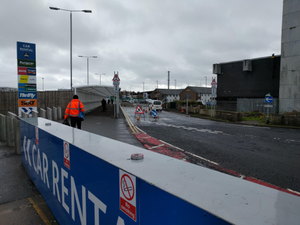
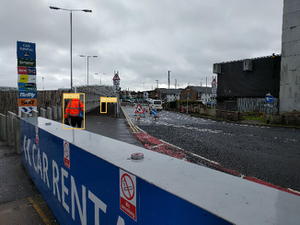
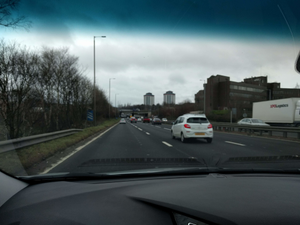
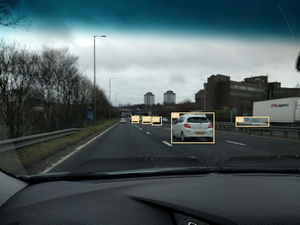
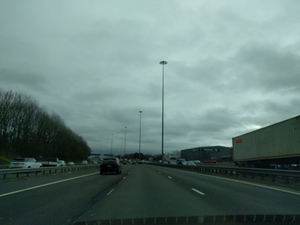
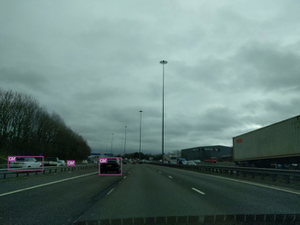
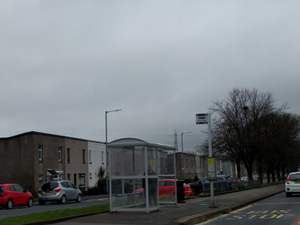
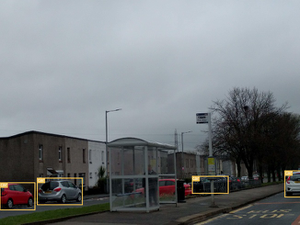
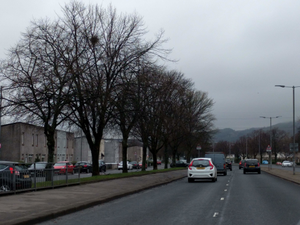
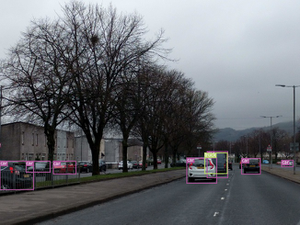
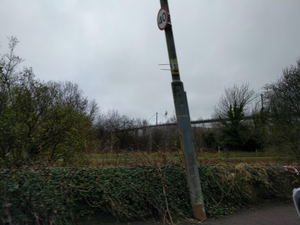
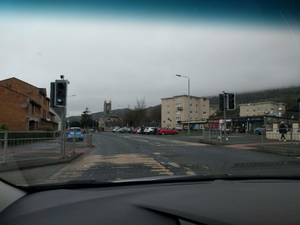
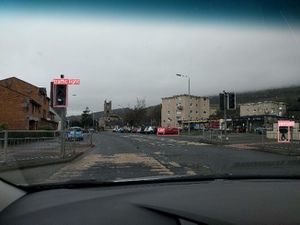

In [16]:
def set_path_for_image(image_path, base_dir, target_folder):
    """ Correct the path of a stored image by concating the filename to the actual media path ( base_dir + target_folder). 
        The base_dir is the dirpath to the classification report (provided via the web app later on)
        
        INPUTS:
        ------------
            image_path - (string) path to the image provided in the classifiication report
            base_dir - (string) dir_path to the classifcation report (e.g. /Volume/.../my_images) 
            target_folder - (string) two possibilities: 1. target_folder = 'images' --> location of the original images
                            2. target_folder = 'images_yolo' --> folder of images generated by Yolo classification
        
        OUTPUTS:
        ------------
            new_path_image - (string) corrected path to the actual image
            
    """
    try:
        path_to_file, filename = os.path.split(image_path)
    
       
        new_path_image = os.path.join(base_dir, target_folder, filename)
        
    
        return new_path_image
    except:
        return None
    
def check_file_path(row):
    """ Check if Yolo image exists. return True if Yes, False if not.
        This True and False definition is needed to create successfully thumbnail images.
        This should be done ONLY if the Yolo Image exists. Otherwise an error would occur.
        
        INPUTS:
        ------------
            row - ( pandas Series) actual chosen row of the classification report DataFrame
            
        
        OUTPUTS:
        ------------
            True/False - (bool) if Yolo image in that row exist, False if not 
             
    """
    try:
        return os.path.isfile(row)
    except:
        return False

def get_thumbnail(path):
    """ Create a thumbnaul image for the actual chosen image
        
        INPUTS:
        ------------
            path - (string) the CORRECTED path to the actual image
        
        OUTPUTS:
        ------------
            i (Image) a thumbnail image for the actual image
    """
    i = Image.open(path)
    i.thumbnail((300, 300), Image.LANCZOS)
    return i

def get_image_asraw_Base64(im):
    """ Convert image back to a readable html tag for the browser
        
        INPUTS:
        ------------
            im - (Image) an Image object 
        
        OUTPUTS:
        ------------
            html_img (string) an html tag for browser displaying
    """
    buffer = io.BytesIO()
    im.save(buffer, format='PNG')
    buffer.seek(0)

    data_uri = base64.b64encode(buffer.read()).decode('ascii')

    #html = '<html><head></head><body>'
    html_img = '<img src="data:image/png;base64,{0}">'.format(data_uri)
    #html += '</body></html>'

    return html_img


def df_as_html(df, base_dir):
    """ Transform the DataFrame with images to HTML object
        
        INPUTS:
        ------------
            df - (pandas dataframe) of the the classification report 
                 (eventiully filtered by datetime AND class items of Yolo and ImageNet)
            
        
        OUTPUTS:
        ------------
            No return 
            filter_result.html - an html file containing the filter output with thumbnail images
    """
    pd.set_option('display.max_colwidth', -1)

    df['image'] = df.apply(lambda row: get_thumbnail(set_path_for_image(row['path_to_file'], base_dir, 'images')), axis = 1)
    df['exists'] = df.apply(lambda row: check_file_path(set_path_for_image(row['img_path_yolo'], base_dir, 'images_yolo')), axis = 1)

    df['image_yolo'] = df.apply(lambda row: get_thumbnail(set_path_for_image(row['img_path_yolo'], base_dir, 'images_yolo')) if row['exists'] == True else None, axis = 1)

    try:
        df.drop('exists', inplace =True, axis=1)
    except:
        pass


    # Convert DataFrame to HTML, displaying PIL.Image objects embedded in dataframe
    html = df.to_html(formatters={'image': get_image_asraw_Base64, 'image_yolo': get_image_asraw_Base64}, escape=False)

    #with open(image_folder + '.html', 'w') as f:
    with open('filter_result.html', 'w') as f:
        f.write(html)
        

    
df_as_html(df_filter, base_dir=cwd)

HTML(filename="filter_result.html")
